<a href="https://colab.research.google.com/github/khalidpark/whitepaper-DeepLearning/blob/main/deep_learning_whitepaper_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 설정

In [8]:
#!pip install tf-nightly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers


## 데이터세트 다운로드

이 튜토리얼에서는 [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) 데이터세트를 사용합니다. 편의를 위해 [TensorFlow Datasets](https://www.tensorflow.org/datasets)를 사용하여 데이터세트를 다운로드합니다. 데이터를 가져오는 다른 방법을 알아보려면 [이미지 로드](https://www.tensorflow.org/tutorials/load_data/images) 튜토리얼을 참조하세요.


In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


꽃 데이터세트에는 5개의 클래스가 있습니다.

In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색하고 이를 사용하여 데이터 증강을 수행하겠습니다.

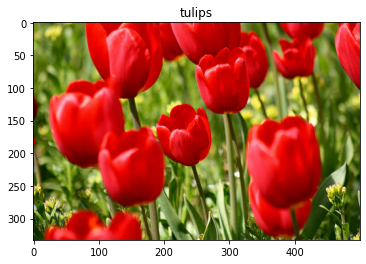

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Keras 전처리 레이어 사용하기

참고: 이 섹션에서 소개하는 [Keras 전처리 레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)는 현재 실험적 단계입니다.

### 크기 및 배율 조정하기


전처리 레이어를 사용하여 이미지를 일관된 모양으로 [크기 조정](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing)하고 픽셀 값의 [배율을 조정](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling)할 수 있습니다.

In [5]:
print(tf.__version__)

2.5.0


In [6]:
print(keras.__version__)

2.5.0


In [7]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

참고: 위의 배율 조정 레이어는 픽셀 값을 `[0,1]`로 표준화합니다. 그렇지 않고 `[-1,1]`을 원할 경우, `Rescaling(1./127.5, offset=-1)`을 작성하면 됩니다.


이러한 레이어를 이미지에 적용한 결과를 볼 수 있습니다. 

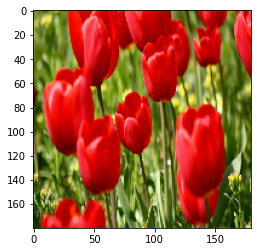

In [8]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

픽셀이 `[0-1]`에 있는지 확인할 수 있습니다.

In [9]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### 데이터 증강

데이터 증강에도 전처리 레이어를 사용할 수 있습니다.

몇 개의 전처리 레이어를 만들어 동일한 이미지에 반복적으로 적용 해 보겠습니다.

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

In [11]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

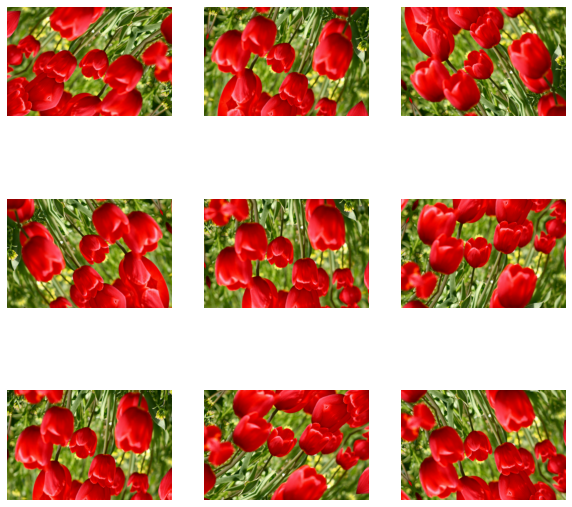

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

`layers.RandomContrast`, `layers.RandomCrop`, `layers.RandomZoom` 등 데이터 증강에 사용할 수 있는 다양한 전처리 [레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)가 있습니다.

### 전처리 레이어를 사용하는 두 가지 옵션

중요한 절충을 통해 이러한 전처리 레이어를 사용할 수 있는 두 가지 방법이 있습니다.

#### 옵션 1: 전처리 레이어를 모델의 일부로 만들기

In [13]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

이 경우 유의해야 할 두 가지 중요한 사항이 있습니다.

- 데이터 증강은 나머지 레이어와 동기적으로 기기에서 실행되며 **GPU 가속**을 이용합니다.

- `model.save`를 사용하여 모델을 내보낼 때 전처리 레이어가 모델의 나머지 부분과 함께 저장됩니다. 나중에 이 모델을 배포하면 레이어 구성에 따라 이미지가 자동으로 표준화됩니다. 이를 통해 서버측 논리를 다시 구현해야 하는 노력을 덜 수 있습니다.

참고: 데이터 증강은 테스트할 때 비활성화되므로 입력 이미지는 `model.fit`(`model.evaluate` 또는 `model.predict`가 아님) 호출 중에만 증강됩니다.

#### 옵션 2: 데이터세트에 전처리 레이어 적용하기

In [14]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

이 접근 방식에서는 `Dataset.map`을 사용하여 증강 이미지 배치를 생성하는 데이터세트를 만듭니다. 이 경우에는 다음과 같습니다.

- 데이터 증강은 **CPU**에서 비동기적으로 이루어지며 차단되지 않습니다. 아래와 같이 `Dataset.prefetch`를 사용하여 GPU에서 모델 훈련을 데이터 전처리와 중첩할 수 있습니다.
- 이 경우, 전처리 레이어는 `model.save`를 호출할 때 모델과 함께 내보내지지 않습니다. 저장하기 전에 이 레이어를 모델에 연결하거나 서버측에서 다시 구현해야 합니다. 훈련 후, 내보내기 전에 전처리 레이어를 연결할 수 있습니다.


[이미지 분류](https://www.tensorflow.org/tutorials/images/classification) 튜토리얼에서 첫 번째 옵션의 예를 볼 수 있습니다. 여기에서는 두 번째 옵션을 살펴보겠습니다.

### 데이터세트에 전처리 레이어 적용하기

위에서 생성한 전처리 레이어로 훈련, 검증 및 테스트 데이터세트를 구성합니다. 또한 병렬 읽기 및 버퍼링된 프리페치를 사용하여 I/O 차단 없이 디스크에서 배치를 생성하여 성능을 높이도록 데이터세트를 구성합니다. [tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance) 가이드에서 데이터세트 성능에 대해 자세히 알아볼 수 있습니다. 

참고: 데이터 증강은 훈련 세트에만 적용해야 합니다.

In [15]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### 모델 훈련하기

완성도를 높이기 위해 이제 이러한 데이터세트를 사용하여 모델을 훈련합니다. 이 모델은 정확성에 목표를 두고 조정되지 않았습니다(작동 방식을 시연하는 것이 목표임).

In [17]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 28s 117ms/step - loss: 1.2636 - accuracy: 0.4595 - val_loss: 1.1074 - val_accuracy: 0.5613
Epoch 2/5
92/92 [==============================] - 9s 95ms/step - loss: 1.0282 - accuracy: 0.5783 - val_loss: 1.0810 - val_accuracy: 0.5967
Epoch 3/5
92/92 [==============================] - 9s 95ms/step - loss: 0.9528 - accuracy: 0.6165 - val_loss: 0.8993 - val_accuracy: 0.6757
Epoch 4/5
92/92 [==============================] - 9s 95ms/step - loss: 0.8998 - accuracy: 0.6451 - val_loss: 0.8430 - val_accuracy: 0.6921
Epoch 5/5
92/92 [==============================] - 9s 96ms/step - loss: 0.8734 - accuracy: 0.6550 - val_loss: 0.9149 - val_accuracy: 0.6431


In [20]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 43ms/step - loss: 0.8320 - accuracy: 0.6866
Accuracy 0.6866484880447388


### 사용자 정의 데이터 증강

사용자 정의 데이터 증강 레이어를 만들 수도 있습니다. 이 튜토리얼에서는 두 가지 방법을 소개합니다. 먼저, `layers.Lambda` 레이어를 생성합니다. 이것은 간결한 코드를 작성하는 좋은 방법입니다. 다음으로, 제어력을 높여주는 [서브 클래스 생성](https://www.tensorflow.org/guide/keras/custom_layers_and_models)을 통해 새 레이어를 작성합니다. 두 레이어는 확률에 따라 이미지의 색상을 무작위로 반전합니다. 

In [21]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [22]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

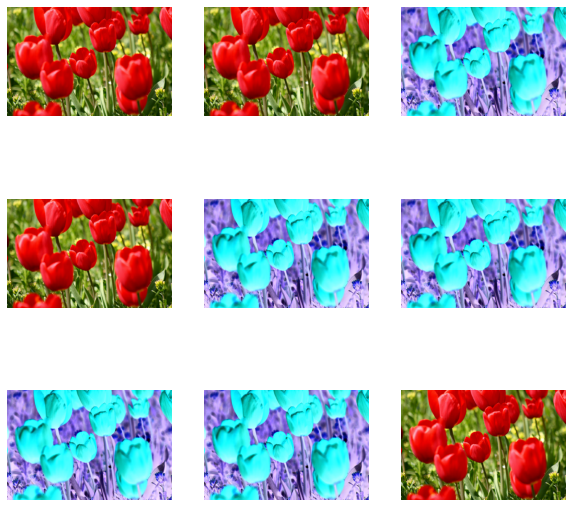

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

다음으로, [서브 클래스 생성](https://www.tensorflow.org/guide/keras/custom_layers_and_models)을 통해 사용자 정의 레이어를 구현합니다.

In [24]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

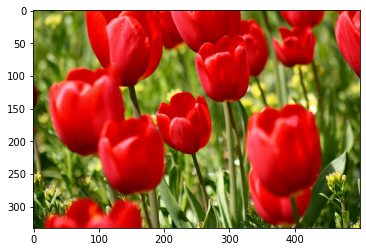

In [25]:
_ = plt.imshow(RandomInvert()(image)[0])

위의 옵션 1과 2의 설명에 따라 이 두 레이어를 모두 사용할 수 있습니다.

## tf.image 사용하기

위의 `layers.preprocessing` 유틸리티는 편리합니다. 보다 세밀한 제어를 위해서는 `tf.data` 및 `tf.image`를 사용하여 고유한 데이터 증강 파이프라인 또는 레이어를 작성할 수 있습니다. [TensorFlow 애드온 이미지: 작업](https://www.tensorflow.org/addons/tutorials/image_ops) 및 [TensorFlow I/O: 색 공간 변환](https://www.tensorflow.org/io/tutorials/colorspace)도 확인해보세요.

꽃 데이터세트는 이전에 데이터 증강으로 구성되었으므로 다시 가져와서 새로 시작하겠습니다.

In [26]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

작업할 이미지를 검색합니다.

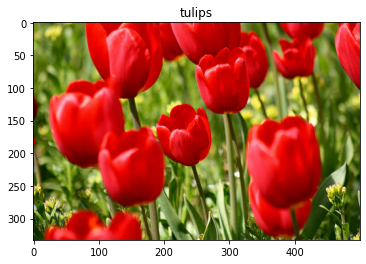

In [27]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

다음 함수를 사용하여 원본 이미지와 증강 이미지를 나란히 시각화하고 비교하겠습니다.

In [28]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### 데이터 증강

### 이미지 뒤집기

이미지를 수직 또는 수평으로 뒤집습니다.

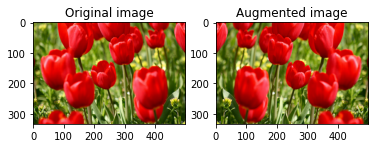

In [29]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### 이미지를 회색조로 만들기

이미지를 회색조로 만듭니다.

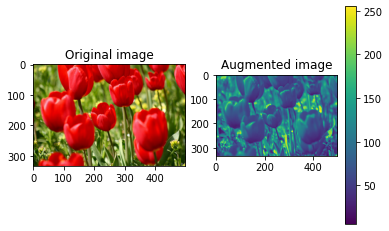

In [30]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

### 이미지 포화시키기

채도 계수를 제공하여 이미지를 포화시킵니다.

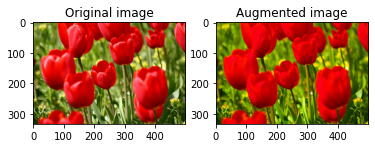

In [31]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### 이미지 밝기 변경하기

밝기 계수를 제공하여 이미지의 밝기를 변경합니다.

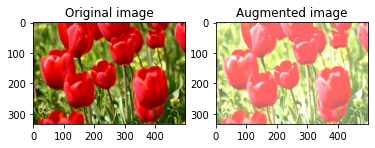

In [32]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### 이미지 중앙 자르기

이미지를 중앙에서 원하는 이미지 부분까지 자릅니다.

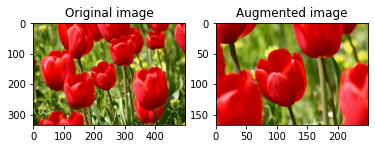

In [33]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

### 이미지 회전하기

이미지를 90도 회전합니다.

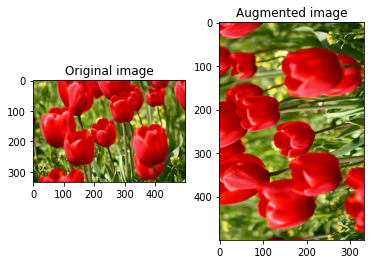

In [34]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### 데이터세트에 증강 적용하기

이전과 마찬가지로 `Dataset.map`을 사용하여 데이터 증강을 데이터세트에 적용합니다.

In [35]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [36]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

### 데이터세트 구성하기

In [37]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
) 

In [38]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [39]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

이제 이러한 데이터세트를 사용하여 이전에 표시한 대로 모델을 훈련할 수 있습니다.

# 객체 인식 (Object Recognition) : 사전 학습된 이미지 분류 신경망을 사용하여 다중 객체 검출하기

- CNN의 가운데 레이어의 출력 결과인 피쳐 맵 위에 슬라이딩 윈도우를 올린다. 
- 사전 학습된 신경망은 해당 이미지의 클래스를 반환한다. 
- 만약 이미지에서 서로다른 객체가 검출되면 확률값을 둘로 쪼개서 반환한다. 
- 하나의 객체만 나오더라도 충분한 활률값이 아니면 분할하여 반환한다. 

다중객체를 찾는 방법의 하나는 이미지 이ㅜ에 슬라이딩 윈도우를 올리고 윈도우 내에서 단일 객체 검출을 시도하는 것이다. 이미지를 224x224로 다운 샘플링 하는 대신에 원본을 두배로 을려 448x448로 샘플링을 한다. 그 다움 Crop된 이미지를 만들어 분류기에 넣는다. 



In [40]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 183kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [41]:
from keras.applications import vgg16
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, TimeDistributed
import numpy as np
from collections import Counter, defaultdict
from keras.preprocessing import image
from PIL import ImageDraw

from scipy.misc import imread, imresize, imsave, fromimage, toimage

try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [42]:
def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def preprocess_image(image_path, target_size=None):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x, w, h):
    x = x.copy()
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, w, h))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((w, h, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [43]:
base_model = vgg16.VGG16(weights='imagenet', include_top=True)
base_model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [46]:
from google.colab import files
files.upload()

Saving cat_dog.jpg to cat_dog.jpg


{'cat_dog.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x96\x00\x96\x00\x00\xff\xdb\x00C\x00\x10\x0b\x0c\x0e\x0c\n\x10\x0e\r\x0e\x12\x11\x10\x13\x18(\x1a\x18\x16\x16\x181#%\x1d(:3=<9387@H\\N@DWE78PmQW_bghg>Mqypdx\\egc\xff\xdb\x00C\x01\x11\x12\x12\x18\x15\x18/\x1a\x1a/cB8Bcccccccccccccccccccccccccccccccccccccccccccccccccc\xff\xc0\x00\x11\x08\x02\x1e\x03 \x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x01\x02\x03\x05\x06\x07\xff\xc4\x00<\x10\x00\x02\x02\x01\x03\x02\x05\x02\x04\x05\x04\x01\x04\x02\x03\x01\x01\x02\x00\x03\x11\x04\x12!1A\x05\x13"Qa2q\x14\x81\x91\xa1#B\xb1\xc1\xd1\x06R\xe1\xf03\x15$b\xf1Cr4S\x92%\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xc4\x00$\x11\x01\x01\x00\x02\x02\x02\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x01\x02\x11\x03!\x121AQ\x142\x04\x13"aq\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\x00?\x00N\x10\x

In [47]:
cat_dog = preprocess_image('cat_dog.jpg', target_size=(224, 224))
preds = base_model.predict(cat_dog)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02106662', 'German_shepherd', 0.6387364), ('n02105162', 'malinois', 0.06257645), ('n02109047', 'Great_Dane', 0.034972675)]


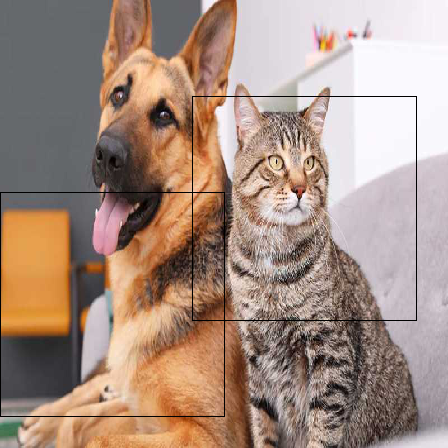

In [48]:
cat_dog_img = image.load_img('cat_dog.jpg', target_size=(448, 448))
draw = ImageDraw.Draw(cat_dog_img)
draw.rectangle((192, 96, 416, 320), outline=(0, 0, 0))
draw.rectangle((0, 192, 224, 416), outline=(0, 0, 0))
cat_dog_img

이미지를 확대한다.

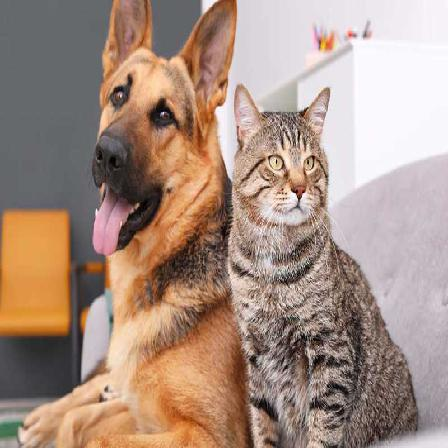

In [49]:
cat_dog2 = preprocess_image('cat_dog.jpg', target_size=(448, 448))
showarray(deprocess_image(cat_dog2, 448, 448))

여러 구획으로 나눠준다. 

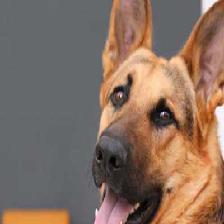

In [50]:
crops = []
for x in range(7):
    for y in range(7):
        crops.append(cat_dog2[0, x * 32: x * 32 + 224, y * 32: y * 32 + 224, :])
crops = np.asarray(crops)
showarray(deprocess_image(crops[0], 224, 224))

각각의 이미지를 분류기에 넣고 어떤 클래스가 나오는 지 확인한다. 

In [51]:
preds = base_model.predict(vgg16.preprocess_input(crops))
crop_scores = defaultdict(list)
for idx, pred in enumerate(vgg16.decode_predictions(preds, top=1)):
    _, label, weight = pred[0]
    crop_scores[label].append((idx, weight))
crop_scores.keys()

dict_keys(['Great_Dane', 'German_shepherd', 'Egyptian_cat', 'lynx', 'tabby', 'tiger_cat', 'Chesapeake_Bay_retriever', 'koala', 'timber_wolf', 'Siberian_husky'])

여러 이미지에서 개나 고양이가 검출된 것을 확인할 수 있다. 그렇나 여러개의 품종으로 검출된 것을 볼 수 있다. 여러개의 레이블 중에서 가장 높은 확률의 이미지를 찾는 것을 실행시켜보자. 

In [52]:
crops.shape

(49, 224, 224, 3)

0


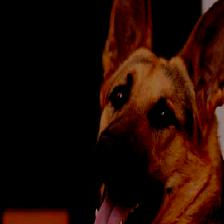

In [55]:
def best_image_for_label(l, label):
    idx = max(l[label], key=lambda t:t[1])[0]
    print(idx)
    return deprocess_image(crops[idx,:,:,:], 224, 224)

showarray(best_image_for_label(crop_scores, 'Great_Dane'))

1


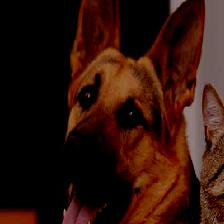

In [56]:
showarray(best_image_for_label(crop_scores, 'German_shepherd'))

In [57]:
def create_top_model(base_model):
    inputs = Input(shape=(7, 7, 512), name='input')
    flatten = Flatten(name='flatten')(inputs)
    fc1 = Dense(4096, activation='relu', name='fc1')(flatten)
    fc2 = Dense(4096, activation='relu', name='fc2')(fc1)
    predictions = Dense(1000, activation='softmax', name='predictions')(fc2)
    model = Model(inputs, predictions, name='top_model')
    for layer in model.layers:
        if layer.name != 'input':
            print(layer.name)
            layer.set_weights(base_model.get_layer(layer.name).get_weights())
    return model

top_model = create_top_model(base_model)
top_model.summary()

flatten
fc1
fc2
predictions
Model: "top_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 7, 7, 512)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 1000)              4097000   
Total params: 123,642,856
Trainable params: 123,642,856
Non-trainable params: 0
_________________________________________________________________


In [58]:
bottom_model = vgg16.VGG16(weights='imagenet', include_top=False)
bottom_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [59]:
p0 = base_model.predict(crops[:1])
vgg16.decode_predictions(p0, top=1)

[[('n02109047', 'Great_Dane', 0.76847667)]]

In [60]:
b0 = bottom_model.predict(crops[:1])
t0 = top_model.predict(b0[:, :, :, :])
vgg16.decode_predictions(t0, top=1)

[[('n02109047', 'Great_Dane', 0.76847667)]]

이제 bottom_model을 이용한 output을 crop하여 입력으로 사용한다. 이렇게 하면 bottom_model을의 수행횟수가 64번에서 4번으로 크게 줄어든다. 먼저 bottom_model에 이미지를 입력하여 그 결과를 bottom_out에 저장한다. 

In [61]:
bottom_out = bottom_model.predict(cat_dog2)
bottom_out.shape

(1, 14, 14, 512)

그리고 bottom_out을 crop 한다.

In [62]:
vec_crops = []
for x in range(7):
    for y in range(7):
        vec_crops.append(bottom_out[0, x: x + 7, y: y + 7, :])
vec_crops = np.asarray(vec_crops)
vec_crops.shape

(49, 7, 7, 512)

In [63]:
t0 = top_model.predict(vec_crops[:1])
vgg16.decode_predictions(t0, top=1)

[[('n02106662', 'German_shepherd', 0.9592965)]]

In [64]:
b0.shape

(1, 7, 7, 512)

In [65]:
crop_pred = top_model.predict(vec_crops)
l = defaultdict(list)
for idx, pred in enumerate(vgg16.decode_predictions(crop_pred, top=1)):
    _, label, weight = pred[0]
    l[label].append((idx, weight))
l.keys()

dict_keys(['German_shepherd', 'Egyptian_cat', 'tabby'])

8


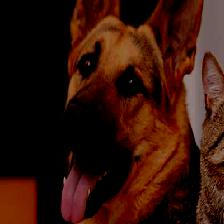

In [67]:
showarray(best_image_for_label(l, 'German_shepherd'))

34


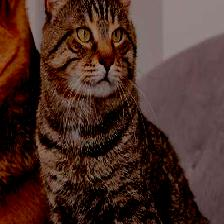

In [68]:
showarray(best_image_for_label(l, 'tabby'))

이렇게 하면 보다 빠르게 결과를 얻을 수 있다. 